In [2]:
import feather
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline
import os


## Read in dataframe

In [117]:

df = feather.read_dataframe('TestDatasets/'+os.environ["file"])


## Use GPy

In [119]:
import GPy

In [193]:
k1=GPy.kern.StdPeriodic(input_dim=1)
k1.unconstrain()
#k1.period.set_prior(GPy.priors.Uniform(lower=0.8,upper=1.2))
k1.period.constrain_bounded(0.8,1.2)
k1.lengthscale.set_prior(GPy.priors.Uniform(lower=0.0,upper=1.0))
k1.variance.set_prior(GPy.priors.Uniform(lower=0.0,upper=1.0))

k2=GPy.kern.RBF(input_dim=1)
k2.unconstrain()
k2.variance.set_prior(GPy.priors.Uniform(lower=0.0,upper=1.0))
k2.lengthscale.constrain_bounded(2,20)

#k2.lengthscale.set_prior(GPy.priors.Uniform(lower=2,upper=20))


k_add = k1+k2

In [181]:
X=np.arange(0,df.size)[:,np.newaxis]/12.0
Y=df['x'][:,np.newaxis]

In [194]:

m = GPy.models.GPRegression(X,Y,k_add)
m.Gaussian_noise.fix(0.05)


array([0])

In [195]:
log_pred=np.zeros((Y.size))

import scipy.stats as st

ii=0
xx = np.arange(0, 400/12.0,1/12.0,dtype=float)[:-1,None]
mean_final=np.zeros(400)[:,None]
variance_final=np.zeros(400)[:,None]
models=[]
changepoints=[]
for i in range(1,Y.size-2):
    m = GPy.models.GPRegression(X[ii:i,:],Y[ii:i,:],k1+k2)
    m.Gaussian_noise.fix(0.01)
    m.optimize()
    m.optimize_restarts(num_restarts=2,verbose=False)
    mean,variance=m.predict(X[i+1:i+2,:])
    log_pred[i]=st.norm.ppf(st.norm.cdf(Y[i+1,:], loc=mean, scale=np.sqrt(variance)))[0]
    if (np.abs(log_pred[i])>3.0) and ((i-ii)>22) or (i==Y.size-2):
        ind=(xx>X[ii]) & (xx<X[i+1])
        #print ii,i,xx[ind][:,None].shape,np.abs(log_pred[i])
        m_tmp,v_tmp=m.predict(xx[ind][:,None])
        #print mean_final[ind].shape,m_tmp
        mean_final[ind]=m_tmp[:,0]
        variance_final[ind]=v_tmp[:,0]
        models.append(m)
        changepoints.append(i)
        ii=i
        
i=Y.size-2
ind=(xx>X[ii])
m_tmp,v_tmp=m.predict(xx[ind][:,None])
#print mean_final[ind].shape,m_tmp
mean_final[ind]=m_tmp[:,0]
variance_final[ind]=v_tmp[:,0]
models.append(m)


 /Users/pdh21/anaconda3/envs/old/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:invalid value encountered in sqrt


KeyboardInterrupt: 

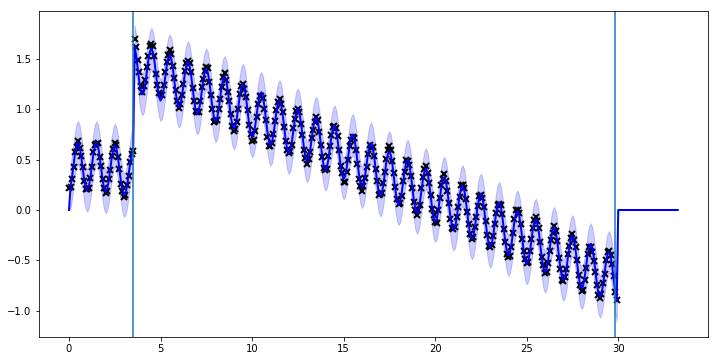

In [190]:
xx = np.arange(0, 400/12.0,1/12.0,dtype=float)[:-1,None]

plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean_final, 'b', lw=2)
plt.fill_between(xx[:,0], mean_final[:,0] - 2*np.sqrt(variance_final[:,0]), mean_final[:,0] + 2*np.sqrt(variance_final[:,0]), color='blue', alpha=0.2)

for c in changepoints:
    plt.axvline(x=X[c])


(-8, 8)

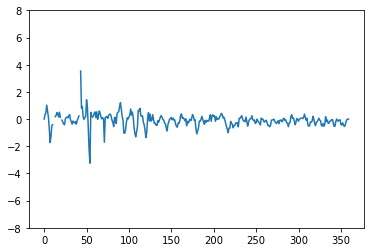

In [191]:
plt.plot(np.arange(0,log_pred.size),log_pred)

plt.ylim(-8,8)

In [192]:
from IPython.display import display
for m in models:
    display(m)

GP_regression.,value,constraints,priors
sum.std_periodic.variance,0.354787922374,,"[0, 1]"
sum.std_periodic.period,1.01337843109,"0.8,1.2",
sum.std_periodic.lengthscale,2.06998399664,,"[0, 1]"
sum.rbf.variance,0.145279902815,,"[0, 1]"
sum.rbf.lengthscale,2.32687211471,,"[2, 20]"
Gaussian_noise.variance,0.01,fixed +ve,


GP_regression.,value,constraints,priors
sum.std_periodic.variance,3.25314948958,,"[0, 1]"
sum.std_periodic.period,0.999745093034,"0.8,1.2",
sum.std_periodic.lengthscale,8.94368615038,,"[0, 1]"
sum.rbf.variance,2.91955373215,,"[0, 1]"
sum.rbf.lengthscale,19.9999998737,,"[2, 20]"
Gaussian_noise.variance,0.01,fixed +ve,
